# Importing

In [ ]:
# ! pip3 install -q kaggle

# ! mkdir ~/.kaggle
# ! cp /home/ignatlegeza/kaggle/kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

# ! kaggle competitions list
# ! kaggle competitions download -c humpback-whale-identification -p ./data/

# ! unzip -q ./data/test.zip -d ./data/test
# ! unzip -q ./data/train.zip -d ./data/train

In [ ]:
import os
import sys
import time
import pickle
from functools import partial
import multiprocessing
import multiprocessing.dummy
num_cores = multiprocessing.cpu_count()

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import BatchSampler # Sampler,
cuda = torch.device('cuda')
cpu = torch.device('cpu')

import torchvision
from torchvision import models, transforms

from tqdm import tqdm
from IPython.display import clear_output

gdrive_path = './models_logs/'

In [ ]:
labels = pd.read_csv('./data/train.csv')

# labels - таблица вида: имя картинки, лейбл кита на ней

In [ ]:
# для удобства кодируем лейблы числами

lblenc = LabelEncoder()

lblenc.fit(labels['Id'])
labels_encoded = lblenc.transform(labels['Id'])
labels['Id_enc'] = labels_encoded

nw_label_enc = lblenc.transform(['new_whale'])[0]

labels.head(5)

,Image,Id,Id_enc
0,0000e88ab.jpg,w_f48451c,4786
1,0001f9222.jpg,w_c3d896a,3808
2,00029d126.jpg,w_20df2c5,662
3,00050a15a.jpg,new_whale,0
4,0005c1ef8.jpg,new_whale,0


In [ ]:
print('train size: ', labels.shape[0])
print('num of classes: ', lblenc.classes_.shape[0])

train size:  25361
num of classes:  5005


In [ ]:
# посчитаем как часто встречается каждый из лейблов

labels_counter = pd.DataFrame(
    {'label': np.unique(labels['Id_enc'], return_counts=True)[0],
     'count': np.unique(labels['Id_enc'], return_counts=True)[1]}
)

labels_counter = labels_counter.sort_values(by='count', ascending=False)
labels_counter = labels_counter.reset_index(drop=True)

labels_counter.head()

,label,count
0,0,9664
1,712,73
2,3029,65
3,3049,62
4,64,61


# Data clearing and making validation

Наша табличка labels является по сути словарем с именами и лейблами всей тренировочной выборки.  
В первом подходе к задаче мы совсем не хотим работать с лейблами у которых только одна картинка (одиночки), потому что к ним просто не найти позитивов. Тренироваться на таких мы не будем, но при получении предиктов мы будем считать расстояние до них.  
Формируя валидационный датасет мы почти вручную достанем 4500 картинок из labels.  
Логика будет следующей:
1. Случайно достаем int(4500 x 0.3) картинок с лейблом new_whale.
2. Для лейблов с двумя и тремя картинками правило следующее: бежим по таким лейблам и достаем одну случайную картинку в тест. Так бежим пока не достигнем максимума, заданного в словаре max_chosen_labels: int(4500 x 0.15) и int(4500 x 0.05).
3. Исключаем из labels все картинки с лейблом new_whale и лейблами, состоящими из 1, 2, 3 картинок. Из получившегося множества рандомно добираем оставшуюся часть валидации int(4500 x 0.5).

In [ ]:
labels_set_initial = set(labels['Id_enc'])

# label_to_indices_initial -- словарь вида: лейбл - индексы картинок с этим лейблом
label_to_indices_initial = {label: np.where(labels['Id_enc'] == label)[0] 
                            for label in labels_set_initial}

In [ ]:
# исключаем из labels лейблы-одиночки

lonely_labels = []
for key in label_to_indices_initial:
    if len(label_to_indices_initial[key]) == 1:
        lonely_labels.append(key)

labels_without_singles = labels[~labels['Id_enc'].isin(lonely_labels)]
labels_without_singles = labels_without_singles.reset_index(drop=True)

In [ ]:
random_state = np.random.RandomState(42)

max_chosen_labels = {
    2: int(4500 * 0.15),
    3: int(4500 * 0.05),
    'other': int(4500 * 0.5)
}

current_chosen_labels = {
    2: 0,
    3: 0,
    'other': 0
}
val_indxs = np.empty(0)
for key in label_to_indices_initial:
    # забиваем 30% валидации картинками с лейблом new_whale
    if key == nw_label_enc:
        chosen_indxs = random_state.choice(label_to_indices_initial[key], int(4500*0.3), replace=False)
        val_indxs = np.append(val_indxs, chosen_indxs)
    # забиваем 15% валидации картинками с лейблом из двух картинок (достаем по одной на лейбл)
    elif len(label_to_indices_initial[key]) == 2 and \
    current_chosen_labels[2] < max_chosen_labels[2]:
        chosen_indxs = random_state.choice(label_to_indices_initial[key], 1)
        val_indxs = np.append(val_indxs, chosen_indxs)
        current_chosen_labels[2] += 1
    # забиваем 5% валидации картинками с лейблом из трех картинок (достаем по одной на лейбл)
    elif len(label_to_indices_initial[key]) == 3 and \
    current_chosen_labels[3] < max_chosen_labels[3]:
        chosen_indxs = random_state.choice(label_to_indices_initial[key], 1)
        val_indxs = np.append(val_indxs, chosen_indxs)
        current_chosen_labels[3] += 1

# мы сформировали 50% валидации. 
# теперь сформируем сет с индексами всех new_whale и лейблов с 2 и 3 картинками.
indxs_to_exclude_for_val = np.empty(0)
indxs_to_exclude_for_val = np.append(indxs_to_exclude_for_val, label_to_indices_initial[nw_label_enc])

labels_with_2_3_imgs = np.array(labels_counter[(labels_counter['count'] >= 1) & 
                                               (labels_counter['count'] <= 3)]['label'])
for label in labels_with_2_3_imgs:
    indxs_to_exclude_for_val = np.append(indxs_to_exclude_for_val, 
                                         label_to_indices_initial[label])

# исключаем из labels все индексы из сета выше и рандомно добираем оставшиеся 50% валидации
chosen_indxs = random_state.choice(
    np.array(list(set([*labels.index]) - set(indxs_to_exclude_for_val))), 
    max_chosen_labels['other'], replace=False
)
val_indxs = np.append(val_indxs, chosen_indxs)
val_indxs = val_indxs.astype(int)

In [ ]:
# формируем новый трейн без картинок, которые отобрали в валдацию
new_train_indxs = np.array(list(set([*labels.index]) - set(val_indxs)))
new_train_labels_with = labels.iloc[new_train_indxs]
new_train_labels_with = new_train_labels_with.reset_index(drop=True)

# уберем из нового трейна лейблы-одиночки, потому что не можем взять для них позитивы
labels_set_new = set(new_train_labels_with['Id_enc'])
label_to_indices_new = {label: np.where(new_train_labels_with['Id_enc'] == label)[0] 
                        for label in labels_set_new}

lonely_labels_new = []
for key in label_to_indices_new:
    if len(label_to_indices_new[key]) == 1:
        lonely_labels_new.append(key)

new_train_labels_without = new_train_labels_with[~new_train_labels_with['Id_enc'].isin(lonely_labels_new)]
new_train_labels_without = new_train_labels_without.reset_index(drop=True)

val_labels_df = labels.iloc[val_indxs]
val_labels_df = val_labels_df.reset_index(drop=True)

test_df = os.listdir('./data/test/')
test_df = pd.DataFrame({'Image': test_df})

In [ ]:
print(
    'initial labels:', labels.shape, '\n',
    'initial labels without lonelis:', labels_without_singles.shape, '\n',
    'new train labels with lonelis:', new_train_labels_with.shape, '\n',
    'new train labels without lonelis:', new_train_labels_without.shape, '\n',
    'val labels with lonelies:', val_labels_df.shape, '\n',
    'test df:', test_df.shape
)

initial labels: (25361, 3) 
 initial labels without lonelis: (23288, 3) 
 new train labels with lonelis: (20861, 3) 
 new train labels without lonelis: (18098, 3) 
 val labels with lonelies: (4500, 3) 
 test df: (7960, 1)


Итого.  
Для тренировки нас интересуют следующие датасеты:

*   new_train_labels_without -- на нем мы будем обучаться (новый трейн без одиночек);
*   val_labels_df -- на нем мы будем валидироваться, измеряя расстояния до всех картинок из new_train_labels_with (новый трейн с одиночками).



# Datasets, dataloaders, etc.

In [ ]:
# Чтобы ускорить обучение, 
#   заранее ресайзнем все картинки и положим в соседнюю директорию

def res_save(item, source_path_nested, resized_path_nested):
    im = Image.open(source_path_nested + item)
    f, _ = os.path.splitext(source_path_nested + item)
    imResize = im.resize((224, 224), Image.ANTIALIAS)
    imResize.save(resized_path_nested + item, 'JPEG', quality=95)

# train resizing
res_save_item = partial(res_save, 
                        source_path_nested='./data/train/', 
                        resized_path_nested='./data/train_resized/')

! mkdir ./data/train_resized/
with multiprocessing.Pool(num_cores) as p:
    p.map(res_save_item, os.listdir('./data/train/'))

# # test resizing
# res_save_item = partial(res_save, 
#                         source_path_nested='./data/test/', 
#                         resized_path_nested='./data/test_resized/')

# ! mkdir ./data/test_resized/
# with multiprocessing.Pool(num_cores) as p:
#     p.map(res_save_item, os.listdir('./data/test/'))

In [ ]:
# WhaleDataset version for model training with making triplets after getting embeddings

class WhaleDataset(Dataset):
    def __init__(self, dataset_folder, labels_df, img_loader, transform=None):
        self.dataset_folder = dataset_folder
        self.labels_df = labels_df
        self.transform = transform
        self.img_loader = img_loader
        
        self.image_names = labels_df['Image']
        self.image_labels = labels_df['Id_enc']
    
    def __len__(self):
        return labels_df.shape[0]
    
    def __getitem__(self, index):
        img = self.img_loader(self.dataset_folder + self.image_names[index])
        img_label = self.image_labels[index]
        
        if self.transform is not None:
            img = self.transform(img)

        return img, img_label

Общая логика формирования тренировочного батча: 50% батча будет состоять из картинок у которых как минимум есть позитивная пара в батче, а остальные 50% достаем рандомно из оставшихся.  
Последовательность следующая:
1. Идем по labels_unique и достаем из каждого лейбла n_i картинок, где n_i <= self.batch_size_half - batched_positives_num.  
Если batched_positives_num < self.batch_size_half то переходим к следующему элементу labels_unique.  
batched_positives_num - количество картинок у которых как минимум есть позитивная пара в батче.
2. Получается, что вместе с формированием батчей мы перебираем лейблы. Как только они закончатся, мы остановим внутренний цикл и вылетим из условия цикла while.  

Из-за формирования labels_unique в init, мы будем каждую эпоху заново создавать объект класса WhaleSampler

In [ ]:
class WhaleSampler(BatchSampler):
    def __init__(self, labels:np.ndarray, batch_size):
        self.labels = labels
        
        self.labels_unique = np.unique(labels)
        # del nw_class
        self.labels_unique = np.delete(self.labels_unique, 
                                       np.where(self.labels_unique == nw_label_enc)[0])
        # mix (just in case)
        self.labels_unique = np.random.choice(self.labels_unique, 
                                              len(self.labels_unique), 
                                              replace=False)
        self.labels_unique_len = len(self.labels_unique)
        
        self.labels_indxs = np.arange(len(labels))
        self.label_to_indxs = {label: np.where(labels == label)[0] 
                               for label in self.labels_unique}
        
        self.batch_size = batch_size
        self.batch_size_half = batch_size // 2
        
    
    def __iter__(self):
        current_label = self.labels_unique[0]
        while current_label in self.labels_unique:
            batch = []
            
            # batching positives
            batched_positives_num = 0
            while batched_positives_num < self.batch_size_half:
                current_label_indxs = self.label_to_indxs[current_label]
                current_label_indxs_len = len(current_label_indxs)
                
                # get positives from current_label
                if current_label_indxs_len < self.batch_size_half - batched_positives_num:
                    batch.extend(current_label_indxs)
                    
                    batched_positives_num += current_label_indxs_len
                    
                    next_label_pos = np.where(self.labels_unique == current_label)[0][0] + 1
                    if next_label_pos < self.labels_unique_len - 1:
                        current_label = self.labels_unique[next_label_pos]
                    else: 
                        # only for out from loop while current_label in self.labels_unique:
                        current_label = 1e+6
                        break
                else:
                    batch.extend(
                        np.random.choice(current_label_indxs, 
                                         self.batch_size_half - batched_positives_num, 
                                         replace=False)
                    )
                    
                    batched_positives_num += self.batch_size_half - batched_positives_num
                    
                    next_label_pos = np.where(self.labels_unique == current_label)[0][0] + 1
                    if next_label_pos < self.labels_unique_len - 1:
                        current_label = self.labels_unique[next_label_pos]
                    else: 
                        # only for out from loop while current_label in self.labels_unique:
                        current_label = 1e+6
                        break
                
            # batching negatives
            batch.extend(
                np.random.choice(self.labels_indxs, 
                                 self.batch_size - self.batch_size_half, 
                                 replace=False)
            )
            
            yield batch

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

def imgshow_tensor(img):
    img = img.numpy().transpose((1,2,0))
    img = img * std + mean
    plt.imshow(img)
    plt.grid(False)
    plt.pause(0.01)

In [ ]:
# Dataset для валидации. Тут триплеты собираются при инициализации

class WhaleDataset_val(Dataset):
    def __init__(self, dataset_folder, labels_df, mode='val', transform=None):
        self.dataset_folder = dataset_folder
        self.labels_df = labels_df
        self.image_names = labels_df['Image']
        self.mode = mode
        self.transform = transform
        
        if mode == 'val':
            self.not_nw_indxs = labels_df[labels_df['Id'] != 'new_whale'].index
            self.labels_set = set(labels_df['Id_enc'])
            self.label_to_indices = {label: np.where(labels_df['Id_enc'] == label)[0]
                                     for label in self.labels_set}
            
            random_state = np.random.RandomState(42)
            triplets = [
                [
                    self.image_names[indx],
                    self.image_names[
                        random_state.choice(
                            self.label_to_indices[labels_df['Id_enc'][indx]]
                        )
                    ],
                    self.image_names[
                        random_state.choice(
                            self.label_to_indices[
                                np.random.choice(
                                    list(
                                        self.labels_set - set([labels_df['Id_enc'][indx]])
                                    )
                                )
                            ]
                        )
                    ]
                ]
                for indx in self.not_nw_indxs
            ]
            self.triplets = triplets
    
    def __len__(self):
        if self.mode != 'test':
            return len(self.not_nw_indxs)
        elif self.mode == 'test':
            return self.labels_df.shape[0]
    
    def __getitem__(self, index):
        if self.mode == 'val':
            path1, path2, path3 = self.triplets[index]
            img1 = Image.open(self.dataset_folder + path1).convert('RGB')
            img2 = Image.open(self.dataset_folder + path2).convert('RGB')
            img3 = Image.open(self.dataset_folder + path3).convert('RGB')
            
            if self.transform is not None:
                img1 = self.transform(img1)
                img2 = self.transform(img2)
                img3 = self.transform(img3)
        
            return img1, img2, img3
        
        elif self.mode == 'test':
            img1 = Image.open(self.dataset_folder + self.image_names[index]).convert('RGB')
            
            if self.transform is not None:
                img1 = self.transform(img1)
            
            return img1

# Make preds and metrics calculating

In [ ]:
# mAP@5

def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0

def map_per_set(labels, predictions):
    """Computes the average over multiple images.

    Parameters
    ----------
    labels : list
             A list of the true labels. (Only one true label per images allowed!)
    predictions : list of list
             A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """
    return np.mean([map_per_image(l, p) for l, p in zip(labels, predictions)])

Предикты делаем предельно просто: прогоняем через сеть весь тестовый и тренировочный датасеты, получаем эмбеддинги, считаем расстояния всех тестовых эмбеддингов со всеми тренировочными. После, для каждого тестового объекта находим индекс тренировочного объекта с минимальным расстоянием.

In [ ]:
def batch_gen(iterable, batch_size=1):
    l = len(iterable)
    for ndx in range(0, l, batch_size):
        yield iterable[ndx:min(ndx + batch_size, l)]


class make_preds():
    def __init__(self):
        self.dataset_folders = {'train': None, 'test': None}
        self.label_dfs = {'train': None, 'test': None}
        self.distances = None
        self.len_embdd = None


    def calc_embeddings(self, model, embedding_type,
                       dataset_folder, labels_df, transforms, 
                       batch_size=2**5, num_workers=4):
        assert embedding_type in ['train', 'test'], \
            "embedding_type must be in ['train', 'test']"
        self.dataset_folders.update({embedding_type: labels_df})
        self.label_dfs.update({embedding_type: labels_df})
        
        model.to(cuda)
        model.eval()

        test_dataset = WhaleDataset_val(dataset_folder=dataset_folder, 
                                        labels_df=labels_df, 
                                        mode='test', 
                                        transform=transforms)
        inference_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                       batch_size=batch_size, 
                                                       shuffle=False, 
                                                       num_workers=num_workers)

        embeddings = torch.Tensor().to(cuda)

        for data in tqdm(inference_loader, desc='calc embeddings', position=0):
            data = data.to(cuda)

            with torch.no_grad():        
                embd = model.get_embedding(data)
                embeddings = torch.cat((embeddings, embd))
        
        if embedding_type == 'train':
            self.train_embdds = embeddings
        elif embedding_type == 'test':
            self.test_embdds = embeddings
        
        del test_dataset, inference_loader, data, embeddings


    def get_distances(self, batch_dist_size=20):
        self.num_train_embdds = self.train_embdds.shape[0]
        self.num_test_embdds = self.test_embdds.shape[0]
        self.len_embdd = self.test_embdds.shape[1]
        
        batch_indxs = [*batch_gen(np.arange(self.num_test_embdds), 
                                  batch_size=batch_dist_size)]
        distances = torch.Tensor([]).view((0, self.num_train_embdds)).to(cuda)
        
        for batch in tqdm(batch_indxs, desc='calc distances', position=0):            
            dist = torch.norm((self.test_embdds[batch].view(-1, 1, self.len_embdd) - self.train_embdds), 
                              dim=-1)
            distances = torch.cat((distances, dist))
        
        self.distances = distances.to(cpu).numpy()
        del dist, distances


    def get_preds(self, num_preds=5, agg_func='min'):
        distances = pd.DataFrame(self.distances.T)
        distances['label'] = self.label_dfs['train']['Id_enc'].values
        distances = distances.groupby('label').agg([agg_func]).values

        self.pred_indxs = np.argsort(distances.T)
        pred_labels = np.array([*map(lambda row: lblenc.inverse_transform(row), 
                                     self.pred_indxs[:, 0:num_preds])])

        return pred_labels

# Net architecture & training process

In [ ]:
class siamese_net(nn.Module):
    def __init__(self, encoder_net, loss_margin):
        super(siamese_net, self).__init__()
        self.encoder_net = encoder_net
        self.loss_margin = loss_margin
        
    def forward(self, x, labels, size_average=True):
        embeddings = self.encoder_net(x)
        
        # deviding on L2 norm (FaceNet)
        embeddings = embeddings / torch.norm(embeddings, dim=-1).view(-1, 1)
        
        distances = torch.norm(
            (embeddings[:batch_size // 2].view(-1, 1, embeddings.size()[-1]) - embeddings), dim=-1
        )
        
        identities_matrix = labels[:batch_size // 2].view(-1, 1) - labels
        
        # getting distances for hard positives imgs
        identities_mask_pos = identities_matrix == 0
        identities_dist_pos = distances * identities_mask_pos.type(torch.cuda.FloatTensor)
        dist_pos = torch.max(identities_dist_pos, dim=-1)[0]
        
        # getting distances for hard negatives imgs
        identities_mask_neg = identities_matrix != 0
        identities_dist_neg = distances * identities_mask_neg.type(torch.cuda.FloatTensor)
        identities_dist_neg[identities_dist_neg == 0] = 1e+6 # needed just for not to brake min func
        dist_neg = torch.min(identities_dist_neg, dim=-1)[0]
        
        #calc loss
        losses = F.relu(dist_pos - dist_neg + self.loss_margin)
        return losses.mean() if size_average else losses.sum()
        
    def get_embedding(self, x):
        return self.encoder_net(x)
    
    def forward_val(self, x1, x2, x3):
        x1 = self.encoder_net(x1)
        x1 = x1 / torch.norm(x1, dim=-1).view(-1, 1)
        
        x2 = self.encoder_net(x2)
        x2 = x2 / torch.norm(x2, dim=-1).view(-1, 1)
        
        x3 = self.encoder_net(x3)
        x3 = x3 / torch.norm(x3, dim=-1).view(-1, 1)
        
        return x1, x2, x3

In [ ]:
def plot_save_logs(logs, model_name:str, y_lim=2.05, is_plot=True):
    """
    logs example:
    {
        'loss': {
            'train': [1, 1.5, 0.5, 0.3, 0.2],
            'val_y': [0.5, 0.3],
            'val_x': [600, 1200]
        },
        'metrics': {
            'value': [...],
            'epoch': [...]
        }
    }
    
    """
    with open(gdrive_path + model_name + '_logs.pkl', 'wb') as f:
        pickle.dump(logs, f, pickle.HIGHEST_PROTOCOL)
    
    if is_plot == True:
        fig, ax = plt.subplots(2, 1, figsize=(7, 10))

        ax[0].plot(logs['loss']['train'], label='train', zorder=1)
        ax[0].scatter(x=logs['loss']['val_x'], y=logs['loss']['val_y'], label='val', 
                      zorder=2, marker='+', s=180, c='orange')

        ax[0].set(title = 'loss', xlabel='batch num', ylim=(-0.05, y_lim))
        ax[0].legend(loc='best')
        ax[0].grid(True)


        ax[1].scatter(x=logs['metrics']['epoch'], y=logs['metrics']['value'], 
                      marker='+', s=180, c='blue')

        ax[1].set(title = 'mAP', xlabel='epoch num')
        ax[1].grid(True)

        fig.tight_layout()
        plt.show()

In [ ]:
def train_model(model, optimizer, train_loader, num_epochs, 
                model_name, margin, val_loader=None): 
    logs = {
        'loss': {'train': [], 'val_y': [], 'val_x': []},
        'metrics': {'value': [], 'epoch': []}
    }
    
    model.to(cuda)
    for epoch in range(num_epochs):
        # training process
        new_train_sampler = WhaleSampler(labels=new_train_labels_without['Id_enc'].values, 
                                         batch_size=120)
        train_loader = torch.utils.data.DataLoader(dataset=new_train_dataset,
                                           batch_sampler=new_train_sampler,
                                           shuffle=False,
                                           num_workers=7,
                                           pin_memory=True)
        
        model.train()
        for x, labels in tqdm(train_loader, desc='training', position=0):
            optimizer.zero_grad()
            x, labels = x.to(cuda, non_blocking=True), labels.to(cuda, non_blocking=True)
            
            loss = model.forward(x, labels)
            
            loss.backward()
            optimizer.step()
            
            logs['loss']['train'].append(loss.item())
            
            # plot graphs and save model
            clear_output()
            print('\n', 'epoch=', epoch)
            plot_save_logs(logs, model_name, is_plot=True)
            
        # validating process
        if val_loader != None:
            loss_val_batch = []
            model.eval()
            
            # тут используется другой Dataset -- сразу возвращаются триплеты
            # calculating loss
            for data in tqdm(val_loader, desc='validation', position=0):
                with torch.no_grad():
                    data = tuple(d.to(cuda, non_blocking=True) for d in data)

                    outputs = model.forward_val(*data)

                    loss = F.triplet_margin_loss(*outputs, margin=margin).item() # 1
                    loss_val_batch.append(loss)
            
            logs['loss']['val_y'].append(np.mean(loss_val_batch))
            logs['loss']['val_x'].append(len(logs['loss']['train']) - 1)
            
            # calculating metrics
            embedds_preds.calc_embeddings(model=model,
                                          embedding_type='train',
                                          dataset_folder='./data/train_resized/',
                                          labels_df=new_train_labels_with,
                                          transforms=data_transforms)
            embedds_preds.calc_embeddings(model=model,
                                          embedding_type='test',
                                          dataset_folder='./data/train_resized/',
                                          labels_df=val_labels_df,
                                          transforms=data_transforms)
            
            embedds_preds.get_distances(batch_dist_size=10)
            preds = embedds_preds.get_preds()
            mean_ap = map_per_set(val_labels_df['Id'].values.tolist(), preds.tolist())
            
            logs['metrics']['value'].append(mean_ap)
            logs['metrics']['epoch'].append(epoch)
            
            # plot graphs
            clear_output()
            plot_save_logs(logs, model_name, is_plot=True)
        
        # saving model
        state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
        save_path = gdrive_path + model_name + '_state.pth'
        torch.save(state, save_path)

# Net training

In [ ]:
resnet50 = models.resnet50(pretrained=False)
# resnet101 = models.resnet101(pretrained=False)

encoder = resnet50

In [ ]:
# Encoder modifs

# Modif version 0
# encoder = nn.Sequential(*(list(encoder.children())[:-1]))

# Modif version 1
# снижение размерности эмбеддингов могут показывать лучший результат на ранних эпохах (FaceNet)
encoder.fc = nn.Sequential(nn.Linear(2048, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 256)
                          )

# Modif version 2
# encoder.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# encoder.fc = nn.Sequential(nn.Linear(2048, 1024),
#                            nn.ReLU(),
#                            nn.Linear(1024, 256)
#                           )

In [ ]:
# training on train set with validation part
pil_imopen = lambda x: Image.open(x).convert('RGB')


new_train_dataset = WhaleDataset(dataset_folder='./data/train_resized/',
                                 labels_df=new_train_labels_without,
                                 img_loader=pil_imopen,
                                 transform=data_transforms)

new_train_sampler = WhaleSampler(labels=new_train_labels_without['Id_enc'].values, 
                                 batch_size=150)

train_loader = torch.utils.data.DataLoader(dataset=new_train_dataset,
                                           batch_sampler=new_train_sampler,
                                           shuffle=False,
                                           num_workers=10,
                                           pin_memory=True)


val_dataset = WhaleDataset_val(dataset_folder='./data/train_resized/', 
                               labels_df=val_labels_df, 
                               mode='val', 
                               transform=data_transforms)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=38, 
                                         shuffle=False, 
                                         num_workers=10,
                                         pin_memory=True)


 epoch= 5


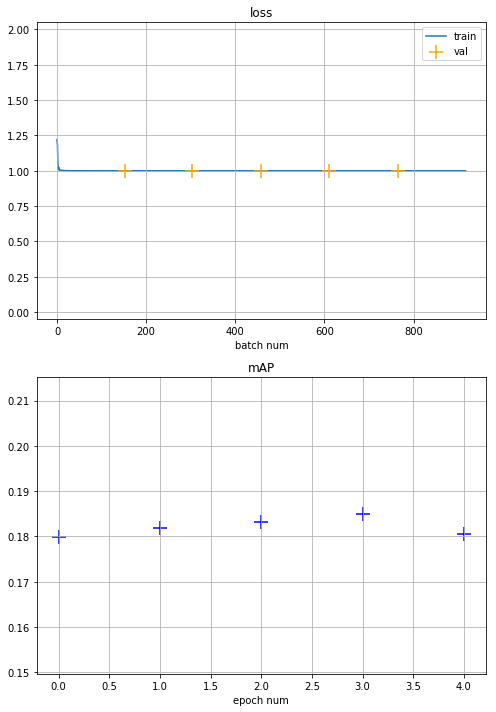

training: 152it [02:14,  1.19it/s]
validation:  55%|█████▌    | 46/83 [00:10<00:07,  4.97it/s]Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ignatlegeza/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ignatlegeza/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/home/ignatlegeza/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/home/ignatlegeza/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ignatlegeza/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ignatlegeza/anaconda3/lib/python3.7/multiprocessing/connection

KeyboardInterrupt: 

In [ ]:
margin = 1
batch_size = 100

resnet_50_hard_triplets = siamese_net(encoder_net=encoder, loss_margin=margin)

optmzr = optim.Adam(resnet_50_hard_triplets.parameters(), lr=1e-3)

embedds_preds = make_preds()
train_model(model=resnet_50_hard_triplets, optimizer=optmzr, train_loader=train_loader, 
            num_epochs=50, model_name='resnet_50_hard_triplets_mg1_v2', margin=margin, 
            val_loader=val_loader)